## Spatial dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import  solve_ivp
from scipy.special import erf
from math import sqrt
from scipy.ndimage import laplace, convolve1d

In [2]:
a_max = 1.
a_min = 0.
na = 401
alpha, dalpha = np.linspace(a_min, a_max, num=na, retstep=True)
r_d = 0.01
r_b = 0.2
p_mut = 1
var = 0.00001
mean_mut_effect = 0
tmax = 50000
Da = var / 2
dens0 = 1 - r_d / r_b
ts = np.linspace(0, tmax, num=101)
nx = 100
xmax = 100
x, dx = np.linspace(0, xmax, nx, retstep=True, endpoint=False)
da = dalpha
p_m = 1
D = 0.00001
K = 1e6
dt = 1
Tfill = xmax / (2 * np.sqrt(D* (1.-r_d)))
tshow = [2, 10, 40, 100]
print(Tfill)

15891.043154093204


In [70]:
def calc_t_half(N0, Ncrit, K, r_d, p_p, s_p, r_b):
    return N0 * Ncrit * (2*K - 3*N0 + 2*Ncrit)/(r_d * p_p * s_p / r_b * (2 * K**2 * N0**2 - 6 * K**2 * N0 * Ncrit + 4 * K**2 * Ncrit**2 - 3 * K * N0**3 + 9 * K * N0**2 * Ncrit - 6 * K * N0 * Ncrit**2 + N0**4 - 3 * N0**3 * Ncrit + 2 * N0**2 * Ncrit**2))

In [201]:
# cancer params
r_d = 0.25
r_b = 0.5
# p_mut = 1
p_l = 1e-8
T_d = 700
# T_d = 1400
T_p = 5e6
# T_p = 1e7
p_d = T_d * p_l
p_p = T_p * p_l
p_mut = 1 - (1 - p_d) * (1 - p_p)
p_pos = T_d / (T_d + T_p)
s_p = 0.001 * r_b
s_d = 0.1 * r_b
tmax = 10000
# Da = var / 2
dens0 = 1 - r_d / r_b
# mean_mut_effect = p_pos * s_d - (1 - p_pos) * s_p
# var = p_pos * s_d**2 + (1 - p_pos) * s_p**2
# secondmommu = var + mean_mut_effect**2
Ncrit = T_p * (s_p / r_b) / T_d / (s_d/r_b)**2
mucrit = s_d / T_p / r_b


L0 = 20
K = round(np.ceil(Ncrit/L0))
N0 = dens0 * K
l = round(np.ceil(4 * Ncrit / K))
t_half = calc_t_half(N0*L0, Ncrit, K*L0, r_d, p_p, s_p, r_b)
vcrit = L0 / t_half / 2
vtarget = vcrit
gamma = -np.log(vtarget**2 / (4 * (r_b - r_d)))
D = 1. / (2 + np.exp(gamma))
Tfill = l / (2 * np.sqrt(D * (r_b - r_d)))
print(Tfill, gamma)

2002.9550496297368 6.437508852972968


In [202]:
K

36

In [203]:
t_half, vcrit

(249.96965224669222, 0.04000485623003193)

In [204]:

tmax = 10000
dims= l,
nodes = np.zeros((l, 3), dtype=int)
nodes[:L0, -1] = N0
lgca = get_lgca(ib=True, nodes=nodes, bc='refl', interaction='birthdeath_cancerdfe', ve=False, capacity=K,
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='lin', dims=dims, restchannels=1, s_d=s_d, p_d=p_d, p_p=p_p, s_p=s_p, gamma=gamma)
lgca.timeevo(timesteps=tmax, record=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [205]:
skip = round(100 / lgca.dens_t.shape[0]) + 1
lgca.dens_t.astype(bool).shape

(10001, 80)

(1, 2729.7629749154225)

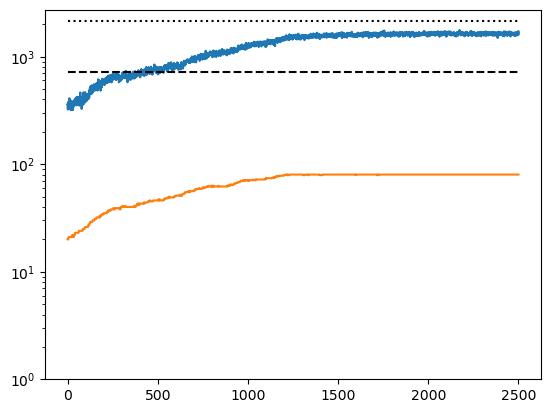

In [206]:
x = np.arange(tmax+1)[::skip] / 4
plt.plot(x, lgca.dens_t.sum(-1)[::skip], label='total cell number')
# plot the number of nonzero nodes
plt.plot(x, lgca.dens_t.astype(bool).sum(-1)[::skip], label='spatial spread')
Nmax = K * (1 - r_d) * l
plt.plot([0, tmax/4], [Ncrit, Ncrit], 'k--', label='$N^*$')
plt.plot([0, tmax/4], [Nmax, Nmax], 'k:', label=r'$N_{\max}$')
plt.yscale('log')
plt.ylim(1)

In [91]:
lgca.plot_density(density_t=lgca.dens_t[::skip])

In [92]:
lgca.plot_prop_timecourse(nodes_t=lgca.nodes_t[::skip])

In [95]:
print(np.sum(lgca.nodes_t.astype(bool)))

In [93]:
lgca.plot_prop_spatial(nodes_t=lgca.nodes_t[::skip])